### Changelog
#### 1. 使用原始数据，未做regularize，使用2层same padding卷积，步长为2的池化，两个全连接层，88.7%的准确率(Linux platform)
#### 2. 和1中的所有操作相同的，但是做了regularize，准确率88.84%(linux platform)
#### 3. 利用2中的regularization，将卷积核的大小改为5，padding为2，准确率为89.15%(windows platform)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
label_to_description = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                        4: 'Coat', 5: 'Sandal', 6: 'Shirt',
                       7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot',
                        }

In [3]:
# path_to_datasets = '/home/lor/Datasets/FashionMNIST/FashionMNIST/processed/training.pt'
path_to_datasets = 'E:/data/FashionMNIST/FashionMNIST/processed/training.pt'
samples = torch.load(path_to_datasets)
features = samples[0]
targets = samples[1]
print(features.shape, targets.shape)
print(targets.max())
print(targets.min())

torch.Size([60000, 28, 28]) torch.Size([60000])
tensor(9)
tensor(0)


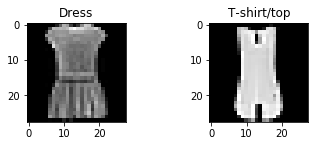

In [4]:
ax = plt.subplot(2, 2, 1)
plt.imshow(np.array(features[3]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[3]])
ax = plt.subplot(2, 2, 2)
plt.imshow(np.array(features[4]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[4]])
plt.show()
# plt.title(label_to_description[targets.storage()[3]])
# label_to_description[targets.storage()[3]]

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
class UserDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        target = self.targets[idx]
        feature = self.features[idx].unsqueeze(0).float()
        feature = (feature - torch.min(feature)) / (torch.max(feature) - torch.min(feature))
        return (target, feature)

In [16]:
train_dataset = UserDataset(features, targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

In [17]:
one_iter = next(iter(train_dataloader))
one_iter[0].reshape(-1)

tensor([1, 8, 3, 0, 5, 5, 9, 5, 2, 7, 4, 3, 0, 4, 0, 3, 6, 2, 9, 3, 9, 3, 3, 6,
        5, 6, 7, 0, 8, 4, 7, 0])

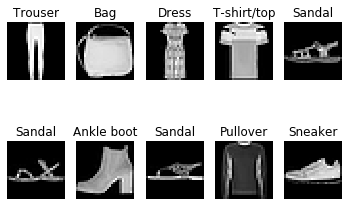

In [18]:
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(one_iter[1][i][0], cmap='gray')
    plt.axis('off')
    ax.set_title(label_to_description[one_iter[0].storage()[i]])

In [19]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=(5, 5), stride=1, padding=2),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 24, kernel_size=(5, 5), stride=1, padding=2),
                        nn.BatchNorm2d(24),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        
        self.fc1 = nn.Linear(7 * 7 * 24, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        res = self.fc2(out)
        
        return res

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Network()
net.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

total_step = len(train_dataloader)

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, (target, feature) in enumerate(train_dataloader):
        target, feature = target.to(device), feature.to(device)
        out = net(feature)
#         out = out.reshape(-1)
        target = target.reshape(-1)
        criterion = loss(out, target)
        
        optimizer.zero_grad()
        criterion.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, criterion.item()))
        

Epoch [1/10], Step [100/1875], Loss: 1.7990
Epoch [1/10], Step [200/1875], Loss: 1.5226
Epoch [1/10], Step [300/1875], Loss: 0.9955
Epoch [1/10], Step [400/1875], Loss: 1.0018
Epoch [1/10], Step [500/1875], Loss: 1.0303
Epoch [1/10], Step [600/1875], Loss: 0.8267
Epoch [1/10], Step [700/1875], Loss: 0.8425
Epoch [1/10], Step [800/1875], Loss: 0.7761
Epoch [1/10], Step [900/1875], Loss: 0.7510
Epoch [1/10], Step [1000/1875], Loss: 0.6794
Epoch [1/10], Step [1100/1875], Loss: 0.6408
Epoch [1/10], Step [1200/1875], Loss: 0.5702
Epoch [1/10], Step [1300/1875], Loss: 0.7212
Epoch [1/10], Step [1400/1875], Loss: 0.8745
Epoch [1/10], Step [1500/1875], Loss: 0.4035
Epoch [1/10], Step [1600/1875], Loss: 0.7116
Epoch [1/10], Step [1700/1875], Loss: 0.7118
Epoch [1/10], Step [1800/1875], Loss: 0.3631
Epoch [2/10], Step [100/1875], Loss: 0.4034
Epoch [2/10], Step [200/1875], Loss: 0.4195
Epoch [2/10], Step [300/1875], Loss: 0.7409
Epoch [2/10], Step [400/1875], Loss: 0.5350
Epoch [2/10], Step [500

In [22]:
### 验证
test_path = 'E:/data/FashionMNIST/FashionMNIST/processed/test.pt'
# test_path = '/home/lor/Datasets/FashionMNIST/FashionMNIST/processed/test.pt'
test_dataset = torch.load(test_path)
print(test_dataset[0].shape)
print(test_dataset[1].shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


In [23]:
test_dataset = UserDataset(test_dataset[0], test_dataset[1])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [24]:
total = 10000
pred_count = 0
for (target, feature) in test_dataloader:
#     print(target.shape)
#     print(feature.shape)
    target = target.to(device)
    feature = feature.to(device)
    out = net(feature)
#     print(torch.argmax(out, 1))
#     print(target)
#     print(torch.argmax(out, 1) == target)
#     print((torch.argmax(out, 1) == target).sum().item())
    pred_count = pred_count + (torch.argmax(out, 1) == target).sum().item()
#     break
print("Accuracy: {0}%".format(100 * pred_count / total))

Accuracy: 87.46%


In [25]:
# Save the model
torch.save(net.state_dict(), './net.pt')

In [37]:
# Load the model
oth_net = Network()
oth_net.load_state_dict(torch.load('./net.pt'))

<All keys matched successfully>

In [38]:
oth_net.eval()

Network(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1176, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)